In [1]:
import pickle
import datetime
from collections import defaultdict
import rpy2
import pandas as pd
import matplotlib.pyplot as plt
from django.db.models.functions import TruncDay

In [2]:
%load_ext rpy2.ipython

In [3]:
folder = "data/comp1_2019_2/"

In [4]:
with open('%s/questions_per_student.pkl' % folder, 'rb') as pklfile:
    questions_per_student = pickle.load(pklfile)

### Calculate drop-out rate and students submission per week

In [5]:
# d = datetime.date(2020, 1, 1)
students_list = list(questions_per_student.keys())
students_count = []
for c in range(3,11):
    problems = Problem.objects.filter(chapter=c)
    students = UserLog.objects.filter(problem__in=problems, 
#                                       timestamp__lte=d,
                                     user_id__in=students_list).order_by('timestamp').values_list('user_id', 
                                                                                             flat=True,
                                                                        ).order_by('user_id').distinct()
    students_count.append(students.count())
    
    
# Get students that finished  the last exercises
problems = Problem.objects.filter(chapter__in=[9,10])
students = UserLog.objects.filter(problem__in=problems, 
#                                       timestamp__lte=d,
                                     user_id__in=students_list).order_by('timestamp'
                                                                        ).values_list('user_id', 
                                                                                      flat=True,
                                                                            ).order_by('user_id').distinct()
print("Students that submitted in the last 2 weeks: %d" % students.count())

# Get students that finished  the last exercises
problems = Problem.objects.filter(chapter__in=[8, 9,10])
students = UserLog.objects.filter(problem__in=problems, 
#                                       timestamp__lte=d,
                                     user_id__in=students_list).order_by('timestamp'
                                                                        ).values_list('user_id', 
                                                                                      flat=True,
                                                                            ).order_by('user_id').distinct()
print("Students that submitted in the last 3 weeks: %d" % students.count())

Students that submitted in the last 2 weeks: 108
Students that submitted in the last 3 weeks: 125


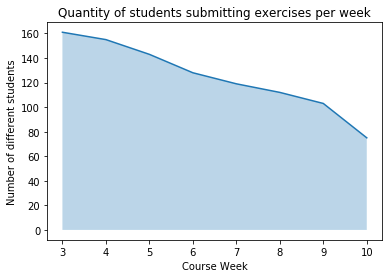

In [6]:
# plt.figure(figsize=(5,4))
plt.plot(range(3,11), students_count)
plt.title("Quantity of students submitting exercises per week")
plt.xlabel("Course Week")
plt.ylabel("Number of different students")
plt.fill_between(range(3,11), students_count, alpha=0.3)
plt.savefig("%s/dropout_rate.png" % folder)
plt.show()

In [14]:
x = list(range(3,11))
students_count

[162, 155, 143, 129, 119, 112, 103, 75]

In [17]:
%%R
cor.test(c(3:10), c(162,155,143,129,119,112,103,75))


	Pearson's product-moment correlation

data:  c(3:10) and c(162, 155, 143, 129, 119, 112, 103, 75)
t = -13.934, df = 6, p-value = 8.514e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9973672 -0.9158607
sample estimates:
      cor 
-0.984898 



In [20]:
%%R
cor(c(5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65), 
         c(16., 15., 13., 15., 14., 13., 14., 12., 14., 15., 14., 10., 16.))

[1] -0.2842083


### Features per week

In [7]:
%%time
data_per_week = defaultdict(dict)
chapters = [3, 4]
for key in questions_per_student.keys():
    for c in chapters:
        problems = Problem.objects.filter(chapter=c)
        outcomes = UserLog.objects.filter(user_id=key, problem__in=problems).order_by('timestamp')
        if outcomes.count():
            outcomes = outcomes.filter(timestamp__lte=outcomes[0].timestamp+datetime.timedelta(weeks=2))
            frequency = outcomes.annotate(day=TruncDay('timestamp')).values('day').order_by('day'
                                                                                           ).distinct().count()
            data_per_week[key].update({"attempts_%s" % c: outcomes.count(),
                              "success_rate_%s" % c: outcomes.filter(outcome='P').count()/outcomes.count(),
                              "s_page_%s"% c: sum(outcomes.values_list('seconds_in_page', flat=True)),
                              "s_code_%s"% c: sum(outcomes.values_list('seconds_in_code', flat=True)),
                              "s_begin_%s"% c: sum(outcomes.values_list('seconds_to_begin', flat=True)),
                              "frequency_%s"% c: frequency
                             })

CPU times: user 7.89 s, sys: 208 ms, total: 8.1 s
Wall time: 6min 8s


### Total features

In [20]:
%%time
data_total = defaultdict(dict)
chapters = [3, 4]
for key in questions_per_student.keys():
    problems = Problem.objects.filter(chapter__in=chapters)
    outcomes = UserLog.objects.filter(user_id=key, problem__in=problems).order_by('timestamp')
    if outcomes.count():
        outcomes = outcomes.filter(timestamp__lte=outcomes[0].timestamp+datetime.timedelta(weeks=2))
        frequency = outcomes.annotate(day=TruncDay('timestamp')).values('day').order_by('day'
                                                                                       ).distinct().count()
        data_total[key].update({"atts": outcomes.count(),
                          "success_rate": outcomes.filter(outcome='P').count()/outcomes.count(),
                          "s_page": sum(outcomes.values_list('seconds_in_page', flat=True)),
                          "s_code": sum(outcomes.values_list('seconds_in_code', flat=True)),
                          "s_begin": sum(outcomes.values_list('seconds_to_begin', flat=True)),
                          "unique_days": frequency
                         })

CPU times: user 3.7 s, sys: 96.9 ms, total: 3.79 s
Wall time: 3min 31s


In [10]:
chapters = [9, 10]
for key in questions_per_student.keys():
    for c in chapters:
        problems = Problem.objects.filter(chapter=c)
        outcomes = UserLog.objects.filter(user_id=key, problem__in=problems).order_by('timestamp')
        if outcomes.count():
            outcomes = outcomes.filter(timestamp__lte=outcomes[0].timestamp+datetime.timedelta(weeks=2))
            data_per_week[key].update({"label": True})
#             data_total[key].update({"label": True})
        else:
            data_per_week[key].update({"label": False})
#             data_total[key].update({"label": False})

In [11]:
df_per_week = pd.DataFrame.from_dict(data_per_week, orient='index')
# df_total = pd.DataFrame.from_dict(data_total, orient='index')

In [12]:
df_per_week['label'].describe()

count       181
unique        2
top       False
freq        106
Name: label, dtype: object

In [23]:
df_per_week.to_csv('%s/dropout_data_per_week.csv' % folder, index=False)
df_total.to_csv('%s/dropout_data_total.csv' % folder, index=False)

In [13]:
%%R
library(gdata)
library(rattle)
library(rpart)
library(e1071)
library(tidyverse)
library(caret)

R[write to console]: gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

R[write to console]: 

R[write to console]: gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

R[write to console]: 
Attaching package: ‘gdata’


R[write to console]: The following object is masked from ‘package:stats’:

    nobs


R[write to console]: The following object is masked from ‘package:utils’:

    object.size


R[write to console]: The following object is masked from ‘package:base’:

    startsWith


R[write to console]: Loading required package: tibble

R[write to console]: Loading required package: bitops

R[write to console]: Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔

In [14]:
df = df_per_week

In [15]:
%%R -i df

set.seed(84)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-label)
test_true <- test_all %>% select(label)
train_s <- train %>% select(-label)
train_true <- train %>% select(label)

priors_false = c(0.6, 0.5, 0.4)
max_depth = c(2,3,4,5,6)
recall = c()
f1 = c()
acc = c()
params_prior = c()
params_maxdepth = c()
for (md in max_depth){
  for (p in priors_false) {
    params_prior = c(params_prior, p)
    params_maxdepth = c(params_maxdepth, md)
    p_true <- 1 - p
    control <- rpart.control(maxdepth=md)
    model = rpart(formula = label ~ ., data = train, method='class', control=control, 
                  parms = list(prior = c(p, p_true), split = "gini"), xval=10)
    # # Prevendo no treino
    train_prediction <- predict(model, newdata=train_s, type='class')
    train_prediction <- as.factor(as.logical(train_prediction))
    train_true <- as.factor(as.logical(unlist(train_true)))
    cm <- caret::confusionMatrix(train_prediction, train_true)
    recall <- c(recall, cm$byClass[6])
    acc <- c(acc, cm$overall[1])
    f1 <- c(f1, cm$byClass[7])
  }
};

print(recall)
print(f1)
print(acc)
print(params_prior)
print(params_maxdepth)

   Recall    Recall    Recall    Recall    Recall    Recall    Recall    Recall 
0.9878049 0.9268293 0.3658537 0.9268293 0.8658537 0.2804878 0.9268293 0.5365854 
   Recall    Recall    Recall    Recall    Recall    Recall    Recall 
0.4512195 0.8780488 0.8170732 0.4512195 0.8780488 0.8170732 0.5243902 
       F1        F1        F1        F1        F1        F1        F1        F1 
0.7714286 0.7600000 0.5042017 0.7875648 0.7759563 0.4339623 0.7875648 0.6518519 
       F1        F1        F1        F1        F1        F1        F1 
0.6065574 0.7955801 0.7836257 0.6065574 0.7955801 0.7836257 0.6666667 
 Accuracy  Accuracy  Accuracy  Accuracy  Accuracy  Accuracy  Accuracy  Accuracy 
0.6689655 0.6689655 0.5931034 0.7172414 0.7172414 0.5862069 0.7172414 0.6758621 
 Accuracy  Accuracy  Accuracy  Accuracy  Accuracy  Accuracy  Accuracy 
0.6689655 0.7448276 0.7448276 0.6689655 0.7448276 0.7448276 0.7034483 
 [1] 0.6 0.5 0.4 0.6 0.5 0.4 0.6 0.5 0.4 0.6 0.5 0.4 0.6 0.5 0.4
 [1] 2 2 2 3 3 3 4 4 4 

### Best models:
1. Prior = 0.6 (NOT COMPLETED) and 0.4 (COMPLETED)
2. Max depth = 3, 4 and 2

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    16    4
     TRUE      8    8
                                          
               Accuracy : 0,6667          
                 95% CI : (0,4903, 0,8144)
    No Information Rate : 0,6667          
    P-Value [Acc > NIR] : 0,5775          
                                          
                  Kappa : 0,3077          
                                          
 Mcnemar's Test P-Value : 0,3865          
                                          
            Sensitivity : 0,6667          
            Specificity : 0,6667          
         Pos Pred Value : 0,8000          
         Neg Pred Value : 0,5000          
             Prevalence : 0,6667          
         Detection Rate : 0,4444          
   Detection Prevalence : 0,5556          
      Balanced Accuracy : 0,6667          
                                          
       'Positive' Class : FALSE           
                     

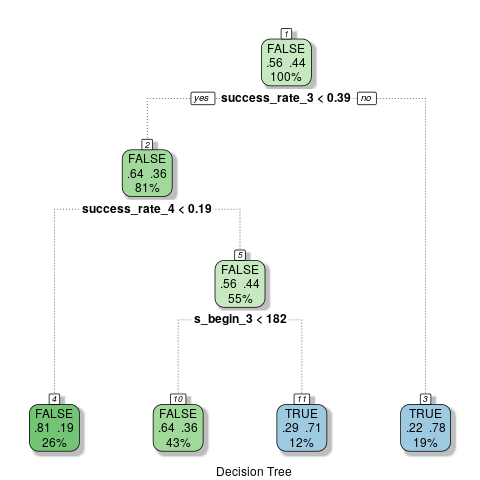

In [16]:
%%R -o cm

set.seed(84)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-label)
test_true <- test_all %>% select(label)
train_s <- train %>% select(-label)
train_true <- train %>% select(label)

control <- rpart.control(maxdepth=3)
model = rpart(formula = label ~ ., data = train, method='class', control=control, 
              parms = list(split = "gini"), xval=10)

fancyRpartPlot(model,sub="Decision Tree")

# # Prevendo no teste
test_prediction <- predict(model, newdata=test, type='class')
test_prediction <- as.factor(as.logical(test_prediction))
test_true <- as.factor(as.logical(unlist(test_true)))
cm <- caret::confusionMatrix(test_prediction, test_true)
print(cm)
print(cm$byClass)
print(cm$byClass[6])
print(cm$overall[1])
print(cm$byClass[7])

In [ ]:
from sklearn import metrics

In [162]:
avg_suc = df.mean()['success_rate_3']
def pred(row):
    if row['success_rate_3'] >= avg_suc:
        return True
    return False
pred_value = test_all.apply(pred, axis=1)

print(metrics.confusion_matrix(test_all['label'], pred_value))
print("F1: %.2f" % metrics.f1_score(test_all['label'], pred_value))
print("Acc: %.2f" % metrics.accuracy_score(test_all['label'], pred_value))
print("Recall: %.2f" %  metrics.recall_score(test_all['label'], pred_value))

[[19  5]
 [ 5  7]]
F1: 0.58
Acc: 0.72
Recall: 0.58


In [163]:
def pred(row):
    if row['success_rate_3'] >= 0.39:
        return True
    return False
pred_value = test_all.apply(pred, axis=1)

print(metrics.confusion_matrix(test_all['label'], pred_value))
print("F1: %.2f" % metrics.f1_score(test_all['label'], pred_value))
print("Acc: %.2f" % metrics.accuracy_score(test_all['label'], pred_value))
print("Recall: %.2f" %  metrics.recall_score(test_all['label'], pred_value))

[[22  2]
 [ 5  7]]
F1: 0.67
Acc: 0.81
Recall: 0.58
